# Fingerprint Siamese Neural Network

## Introduction

This is a Siamese Neural Network that compares the similarity between two fingerpints. This model was trained to compare the similarity between Gabor Enhanced fingerprints, which are fingerprints that were enhanced using Gabor filters. The result of this enhancement technique produces binary enhanced images where black pixels represent part of a ridge in the fingerprint, and white pixels represent the background.

This Siamese Neural Network was adapted from https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py for comparing images or characters. 

This model was run on 2/15/2023.


## Install Dependencies

In [1]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
%reload_ext autoreload
%autoreload

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation

## Config

In [3]:
target_dir   = "../../storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "../../storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

model_results_file = "checkpoint/GAN_results.pt"
model_ckpt_file = "checkpoint/GAN_with_SSNN_checkpoint.pt"

im_size = (300, 300)
var_max = 0.5

num_train = 10000
num_valid = 1000
batch_size = 64
num_workers = 1
shuffle = True
augment = True

# Number of training epochs
num_epochs = 3
start_epoch = 1

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in Siamese Neural Network
ndf = 64

# Learning rate for optimizers
slr = 0.00002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Utils

In [4]:
def saveCkpt(filepath, epoch, netG, netD, netS, optimizerG, optimizerD, optimizerS, G_losses, D_losses, S_losses, img_list, test_batch, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netG_state_dict' : netG.state_dict(),
        'netD_state_dict' : netD.state_dict(),
        'netS_state_dict' : netS.state_dict(),
        'optimizerG_state_dict' : optimizerG.state_dict(),
        'optimizerD_state_dict' : optimizerD.state_dict(),
        'optimizerS_state_dict' : optimizerS.state_dict(),
        'G_losses' : G_losses,
        'D_losses' : D_losses,
        'S_losses' : S_losses,
        'img_list' : img_list,
        'test_batch' : test_batch,
        'iters' : iters,
    }, filepath)


def showImages(batch, labels=None):
    """
    Displays a set of batch images
    
    :param batch: A batch of image pairs and labels to display
    :praam labels: The labels for the images
    """
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()
    
    if labels is not None:
        for l in labels:
            if l == 1:
                print("  same  ", end=" ")
            else:
                print("  diff  ", end=" ")
        
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up synthetically generating my own dataset using this software: https://dsl.cds.iisc.ac.in/projects/Anguli/https://dsl.cds.iisc.ac.in/projects/Anguli/. This generated dataset contains close to one million fingerprint images of varying qualities, which includes 10,000 unique fingerprints. 

In [5]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train 
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    #random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader)



def get_train_valid_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7500]
    validation_prints = fingerprints[7500:]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # Get the Validation Dataloader 
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)
    

class FingerprintLoader(Dataset):
    """
    This class is used to help load the celeba dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset):
        """
        Initializes an instance for the FingerprintLoader class.

        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against 
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = dataset
        self.num_train = num_train
        self.augment = augment

    def __len__(self):
        """
        Helper function to return the length of the dataset

        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset

        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        template_im_filepath = "templateim.jpg"
        template_im_path = ""
        target_im_filepath = "targetim.jpg" 
        enhanced_target_im_filepath = "targetim.jpg"
        
        while not os.path.isfile(template_im_filepath) or not os.path.isfile(target_im_filepath):
            # Chose image 1
            while not os.path.isfile(template_im_filepath):
                template_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset))
                template_im_filepath +=  "/Impression_1/"
                template_im_name = random.choice(self.fingerprints_dataset)
                template_im_filepath += template_im_name + '.jpg'
            # Decide if image is same or not
            label = random.randint(0, 1)
            # Choose image 2
            while not os.path.isfile(target_im_filepath) or not os.path.isfile(enhanced_target_im_filepath):
                target_im_filepath = self.target_dataset + random.choice(os.listdir(self.target_dataset))
                target_im_filepath +=  "/Impression_1/"
                if label == 1:
                    target_im_name = template_im_name
                else:
                    target_im_name = template_im_name
                    while target_im_name == template_im_name:
                        target_im_name = random.choice(self.fingerprints_dataset)
                target_im_filepath = target_im_filepath + target_im_name + '.jpg'
                enhanced_target_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset)) \
                    + "/Impression_1/" + target_im_name + '.jpg'

        label = float(label)
        # Convert images to grayscale
        temp_im = Image.open(template_im_filepath)
        temp_im = temp_im.convert('L')
        targ_im = Image.open(target_im_filepath)
        targ_im = targ_im.convert('L')
        enhanced_targ_im = Image.open(enhanced_target_im_filepath)
        enhanced_targ_im = enhanced_targ_im.convert('L')
        # Pad template image
        w, h = temp_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        template_image = Image.new(temp_im.mode, (dim, dim), 255)
        template_image.paste(temp_im, (left, top))
        # Pad target image
        w, h = targ_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        target_image = Image.new(targ_im.mode, (dim, dim), 255)
        target_image.paste(targ_im, (left, top))
        # Pad enhanced target image
        w, h = enhanced_targ_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        enhanced_target_image = Image.new(enhanced_targ_im.mode, (dim, dim), 255)
        enhanced_target_image.paste(enhanced_targ_im, (left, top))
        # apply transformation on the fly
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                #transforms.CenterCrop(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        target_image = trans(target_image)
        enhanced_target_image = trans(enhanced_target_image)
        template_image = trans(template_image)
        y = torch.from_numpy(np.array([label], dtype=np.float32))
        return target_image, enhanced_target_image, template_image, y

## Data Visualization for the Siamese Neural Network
Below are some sample images that the Siamese Neural Network will be trained on. A dataset of over 100,000 synthetically generated fingerprints. This dataset contains 10,000 distinct fingerprints with each fingerprint have 10 good impressions taken of it. This dataset was generated by using the following software: https://dsl.cds.iisc.ac.in/projects/Anguli/.

Below are some sample images that the Siamese Neural Network was trained on. This images are the Gabor enhanced fingerprints from the dataset, and both the top and bottom rows represent a pair of fingerprints that the model will compare for similarity.

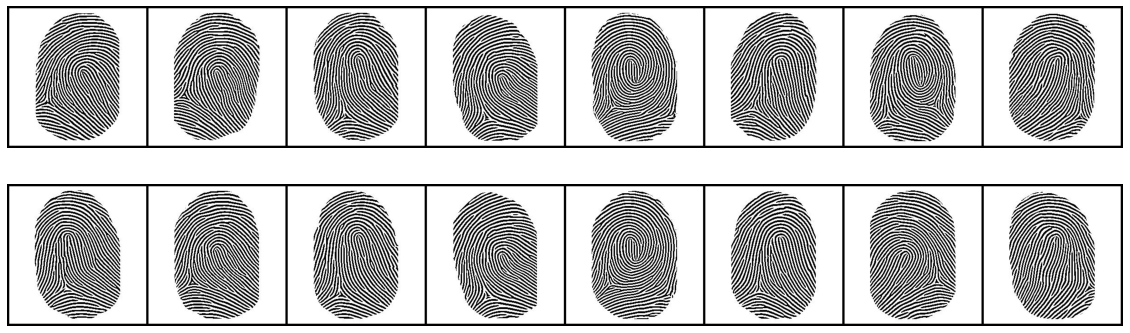

        diff                same               same                same               same                same               diff                same       

In [6]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=8,
                                         shuffle=True, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch
labels = real_batch[3]

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[2].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

c = 0
if labels is not None:
    for l in labels:
        if l == 1:
            print("        same       ", end="")
        else:
            print("        diff       ", end="")
        if c % 2 == 0:
            print(" ", end="")
        c += 1

## Weight Initialization

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

In [8]:
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(1225, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out
        #print(out.shape)
        out = self.fc1(out)
        return torch.sigmoid(out)

    def forward(self, x1, x2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)

        # score the similarity between the 2 encodings
        scores = torch.sigmoid(self.fc2(diff))

        return scores

In [9]:
# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)

# Print the model
print(netS)

SiameseNet(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1225, out_features=512, bias=True)
  (fc2): Linear(in_features=1225, out_features=1, bias=True)
)


## Set Training Params

In [10]:
# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_valid_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]

criterion = nn.BCELoss()

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

## Siamese Neural Network Training

In [11]:
# Train

# Lists to keep track of progress
img_list = []
S_losses = []
iters = 0

print("\n[*] Train on {} sample pairs, validate on {} sample pairs".format(
    num_train, num_valid)
)

gLossMvAvg = MovingAvg()

for epoch in range(start_epoch, num_epochs+1):
    print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
    # switch to train mode
    netS.train()
    train_batch_time = AverageMeter()
    train_losses = AverageMeter()
    tic = time.time()
    training_accuracy = 0.0
    num_correct = 0
    total = 0
    with tqdm(total=num_train) as pbar:
        for i, (x1, enhanced_x1, x2, y) in enumerate(train_loader): 
            x1, enhanced_x1, x2, y = x1.to(device), enhanced_x1.to(device), x2.to(device), y.to(device)
            output = netS(enhanced_x1, x2).view(-1)
            y = y.view(-1)
            errS = criterion(output, y)
            # Calculate the gradients for this batch
            errS.backward()
            # Update S
            optimizerS.step()
            
            for i in range(len(output)):
                label = 0.0
                if output[i] > 0.5:
                    label = 1.0
                if label == y[i]:
                    num_correct += 1
                total += 1
            
            training_accuracy = num_correct / total * 100

            # store batch statistics
            toc = time.time()
            train_batch_time.update(toc-tic)
            tic = time.time()
            pbar.set_description(
                (
                    "loss_S: {:.3f}   training accuracy: {:.6f}".format(errS.item(), training_accuracy)
                )
            )
            pbar.update(batch_size)
            
            # Save Losses for plotting later
            S_losses.append(errS.item())
            
    # Validate
    netS.eval()
    validation_accuracy = 0.0
    num_valid_correct = 0
    total_valid = 0
    for i, (x1, enhanced_x1, x2, y) in enumerate(valid_loader): 
        x1, enhanced_x1, x2, y = x1.to(device), enhanced_x1.to(device), x2.to(device), y.to(device)
        output = netS(enhanced_x1, x2).view(-1)
        y = y.view(-1)
            
        for i in range(len(output)):
            label = 0.0
            if output[i] > 0.5:
                label = 1.0
            if label == y[i]:
                num_valid_correct += 1
            total_valid += 1
            
    validation_accuracy = num_valid_correct / total_valid * 100
    print("validataion accuracy:  {:.6f}".format(validation_accuracy))
            
        


[*] Train on 10000 sample pairs, validate on 1000 sample pairs

Epoch: 1/3


loss_S: 0.271   training accuracy: 68.270000: : 10048it [01:24, 119.14it/s]                        


validataion accuracy:  84.100000

Epoch: 2/3


loss_S: 0.275   training accuracy: 91.060000: : 10048it [01:21, 123.02it/s]                        


validataion accuracy:  97.400000

Epoch: 3/3


loss_S: 0.315   training accuracy: 95.330000: : 10048it [01:18, 127.79it/s]                        


validataion accuracy:  98.700000


## Results

### Training Loss

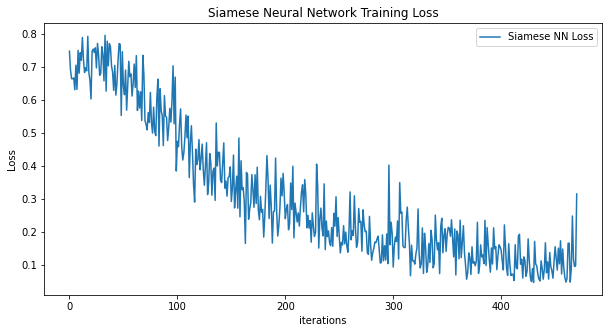

In [12]:
plt.figure(figsize=(10,5))
plt.title("Siamese Neural Network Training Loss")
plt.plot(S_losses,label="Siamese NN Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Sample Performance
Below is plotted 8 pairs of fingerprints. Below each pair of fingerprints, the model will gives its prediction of whether each pair are of the same fingerprint or not. Below that is listed the ground truth.

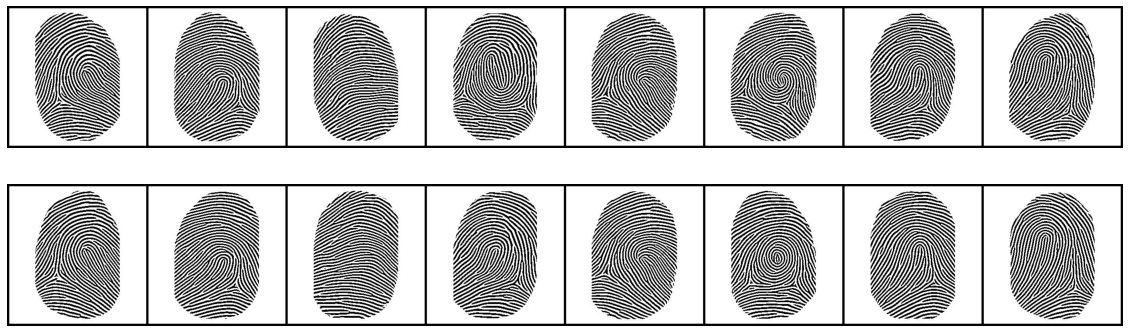

Pred: 
        same                same               same                diff               same                diff               same                same       

Truth:
        same                same               same                diff               same                diff               same                same       



In [59]:
def printLabels(labels):
    c = 0
    for l in labels:
        if l == 1:
            print("        same       ", end="")
        else:
            print("        diff       ", end="")
        if c % 2 == 0:
            print(" ", end="")
        c += 1
    print("\n")


# Get a Batch of Sample Images
disp_fingerprints = [str(finger) for finger in range(7500,10000+1)]  # Fingerprints 7,500 0 10,000 are part of validation set
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=8,
                                         shuffle=True, num_workers=1)
real_batch = next(iter(disp_dataloader))
batch = real_batch
labels = real_batch[3]

# Let model make predictions
netS.eval()
output = netS(batch[1].to(device)[:8], batch[2].to(device)[:8]).view(-1)

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[2].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


# Display Model Performance
preds = [0 if x < 0.5 else 1 for x in output]
    
print("Pred: ")
printLabels(preds)

print("Truth:")
printLabels(labels)    


## Conclusion

It appears that the model was able to achieve decent performance. The model acheived a validation accuracy of 98% during training, and it correctly classified each pair of fingerprints above as the same or different (at least in most cases). One limitation of this model though could be the data that it was trained on. This project assumes that the fingerprints in the dataset are representative of real fingerprints (at least for good impression fingerprints). If there is some problem with the software that was used to generate the fingerprints in this dataset, then the model may not preform well when used on enhanced images of real (good quality) fingerprints.